In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import trange

torch.__version__, torch.cuda.is_available()

('1.4.0', True)

In [2]:
class RNNCell(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNCell, self).__init__()
        self.linear = nn.Linear(in_size + out_size, out_size * 2)

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = torch.tanh(self.linear(inp))
        y, new_h = torch.chunk(out, 2, dim=1)
        return y, new_h

In [3]:
cell = RNNCell(10, 20)
cell = torch.jit.script(cell)

x = torch.rand(5, 10)
h = torch.rand(5, 20)

y, h = cell(x, h)
y.shape, h.shape, x.shape

(torch.Size([5, 20]), torch.Size([5, 20]), torch.Size([5, 10]))

In [4]:
class RNNLoop(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNLoop, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.cell = torch.jit.script(RNNCell(in_size, out_size))
        
    def forward(self, xs):
        bs = xs.size(0)
        seq_size = xs.size(1)

        h = torch.zeros(bs, self.out_size)
        y = torch.zeros(bs, self.out_size)
        rollout = torch.zeros(bs, seq_size, self.out_size)

        for i in range(xs.size(0)):
            y, h = self.cell(xs[:, i], h)
            rollout[:, i] = y

        return rollout

In [5]:
bs = 8
seq_size = 12
in_size = 10
out_size = 20

loop = RNNLoop(in_size, out_size)
loop = torch.jit.script(loop)
print(loop.code)

xs = torch.rand(bs, seq_size, in_size)
loop(xs).shape

def forward(self,
    xs: Tensor) -> Tensor:
  bs = torch.size(xs, 0)
  seq_size = torch.size(xs, 1)
  h = torch.zeros([bs, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  y = torch.zeros([bs, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  rollout = torch.zeros([bs, seq_size, self.out_size], dtype=None, layout=None, device=None, pin_memory=None)
  h0 = h
  for i in range(torch.size(xs, 0)):
    _0 = torch.slice(xs, 0, 0, 9223372036854775807, 1)
    _1 = (self.cell).forward(torch.select(_0, 1, i), h0, )
    y0, h1, = _1
    _2 = torch.slice(rollout, 0, 0, 9223372036854775807, 1)
    _3 = torch.copy_(torch.select(_2, 1, i), y0, False)
    h0 = h1
  return rollout



torch.Size([8, 12, 20])

(torch.Size([784]), torch.Size([784]))

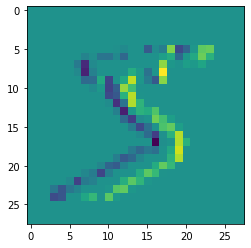

In [65]:
# Trining set

idx = 0
dataset = torchvision.datasets.MNIST(root='./data', download=True)
data = np.array(dataset[idx][0]).reshape(-1) / 255

X, y = torch.Tensor(data), torch.Tensor([*data[1:], 0])
next_batch = lambda: (X.reshape(1, -1, 1), y.reshape(1, -1, 1))

plt.imshow(X.reshape(28, 28) - y.reshape(28, 28))
X.shape, y.shape

In [66]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Model, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.gru = nn.GRU(in_features, hidden_features, batch_first=True)
        self.linear = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        bs = x.size(0)
        h0 = torch.zeros(1, bs, self.hidden_features)

        x, _hn = self.gru(x, h0)
        x = self.linear(x)
        x = torch.sigmoid(x)

        return x

In [76]:
def mk_model():
    in_features = 1
    hidden_features = 10
    out_features = 1
    return torch.jit.script(Model(in_features, hidden_features, out_features))

model = mk_model()
print(model.code)

def forward(self,
    x: Tensor) -> Tensor:
  bs = torch.size(x, 0)
  h0 = torch.zeros([1, bs, self.hidden_features], dtype=None, layout=None, device=None, pin_memory=None)
  x0, _hn, = (self.gru).forward__0(x, h0, )
  x1 = (self.linear).forward(x0, )
  return torch.sigmoid(x1)



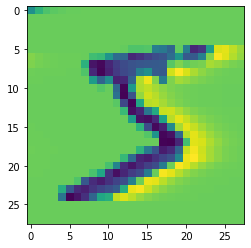

In [77]:
o = model(X.reshape(1, -1, 1)).view(28, 28).detach().numpy()
plt.imshow(o)

In [78]:
def optimize(epochs, model, next_batch):
    history = []
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    t = trange(epochs, desc='Loss: #')
    for i in t:
        optimizer.zero_grad()

        X, y = next_batch()
        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()
        l = loss.item()

        history.append(l)
        t.set_description('Loss: %.5f' % l)
        t.refresh()
        
    return history

In [79]:
history = optimize(100, model, next_batch)

Loss: 0.17905: 100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


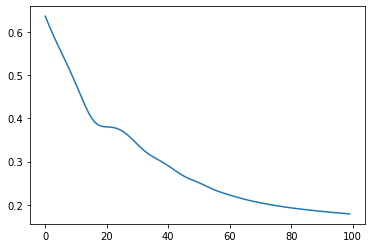

In [80]:
plt.plot(history)

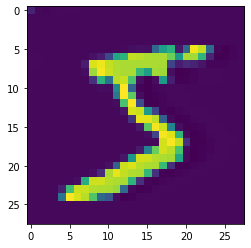

In [81]:
pred = model(X.reshape(1, -1, 1)).reshape(28, 28).detach().numpy()
plt.imshow(pred)